In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
import json
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import fbeta, f1
from sklearn.metrics import fbeta_score

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [10]:
f_model = resnet34
PATH = 'data/iMaterialist/'
TRAIN = 'train_10kv2'
LABEL_CSV = f'{PATH}train_10kv2_labels.csv'
sz=224

Define Metrics

In [11]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, TRAIN, LABEL_CSV, tfms=tfms,
                                        suffix='.jpg', test_name='test')

In [68]:
def f1_max(preds, targs):
    return max([f1(preds, targs, t) for t in np.arange(0.05, 0.5, 0.01)])

def f1_23(preds, targs): return f1(preds, targs, thresh=0.23)

In [69]:
data = get_data(sz)
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=[f1_23])

## Step 1

First we begin retraining the last layer to map training images to our new labels. Because we do not need to send images through all but the last layer more than once, we turn on precompute to cache the vector embeddings before training the last fully connected logistic regression layer.

epoch      trn_loss   val_loss   f1_23      
    0      0.583567   1.126889   0.228896  



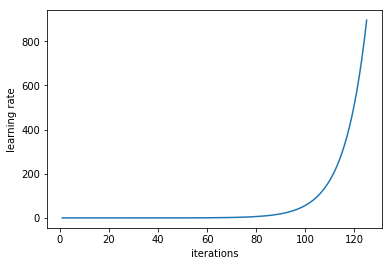

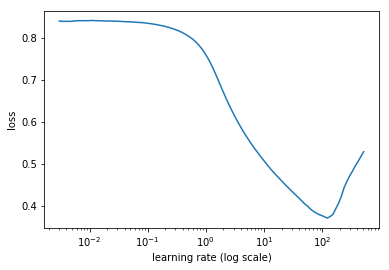

In [70]:
learn.lr_find(start_lr=1e-3, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

We started to see overfitting after 4 epochs. We will stop this initial training at 4 epochs

In [71]:
learn.fit(10, 4)

epoch      trn_loss   val_loss   f1_23      
    0      0.089485   0.071931   0.443709  
    1      0.073752   0.069681   0.46016   
    2      0.070494   0.068429   0.471981  
    3      0.069266   0.068271   0.472821  



[array([0.06827]), 0.47282081169682416]

## Step 2

Lets turn off precompute so we can use randomized crops / brightness levels / zooms for side-on image transformations. We will also add in some cycling of learning rates

In [36]:
learn.precompute=False

In [37]:
learn.fit(2, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.040002   0.039181   0.497105  
    1      0.039974   0.039026   0.498627  
    2      0.039611   0.038923   0.50009   



[array([0.03892]), 0.5000897963147963]

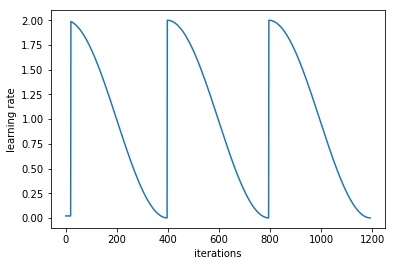

In [38]:
learn.sched.plot_lr()

## Step 3

Let's now tune the beginning, middle, and last layers with a couple more epochs and multiple the cycle len

 96%|█████████▌| 382/397 [01:24<00:03,  4.51it/s, loss=0.16] 

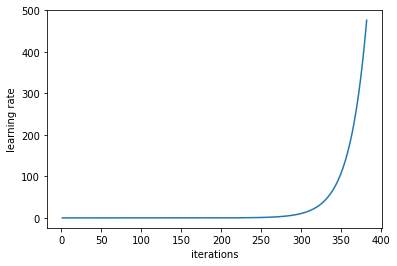

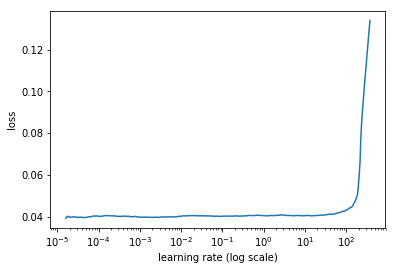

In [20]:
learn.lr_find(start_lr=1e-5, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

In [39]:
learn.unfreeze()
lr=np.array([0.02, .2, 2.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.03958    0.038227   0.508949  
    1      0.038537   0.037651   0.515857  
    2      0.037606   0.037255   0.518394  



[array([0.03725]), 0.5183935593545889]

In [14]:
lr=np.array([1.0, 3.0, 10.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.037921   0.036628   0.473794  
    1      0.036964   0.03613    0.483662  
    2      0.035994   0.035975   0.485593  



[array([0.03598]), 0.485593055289795]

In [15]:
learn.save('resnet34_train_30k_0.485593')

# Load Model and score on test data

In [80]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

In [74]:
f1_23(torch.from_numpy(preds), torch.from_numpy(y))

0.4745659985280748

In [66]:
def opt_th(preds, targs):
    ths = np.arange(0.05, 0.80, 0.01)
    preds = torch.from_numpy(preds)
    targs = torch.from_numpy(targs)
    scores = [f1(preds, targs, th) for th in ths]
    idx = np.argmax(scores)
    print(f'Best Threshold: {ths[idx]}')
    print(f'Best Score: {scores[idx]}')
    print(f'Index: {idx}')

In [67]:
opt_th(preds, y)

Best Threshold: 0.23000000000000004
Best Score: 0.4743065820363447
Index: 18


In [75]:
np.array(data.classes)[(preds[0] > 0.23)]

array(['106', '113', '138', '153', '164', '17', '190', '53'], dtype='<U3')

In [77]:
pd.DataFrame(list(zip(data.classes, y[0])), columns=['class', 'score']).query("score > 0.0")

,class,score
8,106,1.0
59,153,1.0
69,164,1.0
98,190,1.0


In [38]:
pd.read_csv(LABEL_CSV).query("id == 135")

,id,label
5651,135,190 106 153 164


This generates a label for each multilabel where score > 0.5

In [84]:
learn.data.test_ds.

1

In [90]:
def save_results_to_csv(model, data, preds, threshold):
    import pdb; pdb.set_trace();
    cs = np.array(model.data.classes)
    label_preds = list(map(lambda x: ' '.join(cs[x]), (preds > threshold)))
    test_ids = list(map(lambda x: int(x[5:-4]), data.test_ds.fnames))
    
    pred_df = (
        pd.DataFrame(list(zip(test_ids, label_preds)),
                     columns=['image_id', 'label_id'])
        .sort_values('image_id')
        .reset_index(drop=True)
    )
    
    with open('data/iMaterialist/test.json') as f:
        test_urls = pd.DataFrame(json.load(f)['images'])

    with open('data/iMaterialist/validation.json') as f:
        j = json.load(f)
        valid_urls = pd.DataFrame(j['images'])
        valid_labels = pd.DataFrame(j['annotations'])
        valid_labels['labelId'] = valid_labels['labelId'].apply(lambda x: ' '.join(x))
        valid = valid_urls.merge(valid_labels, how='inner', on='imageId')[['url', 'labelId']]
    test_labels = test_urls.merge(valid, how='inner', on='url').drop('url', axis=1)
    
    pred_df.loc[:9896, 'label_id'] = test_labels['labelId'].values
    pred_df.to_csv(f'data/iMaterialist/submission_resnet34_train_30k_0.47_t_{str(threshold)}.csv', index=False)    

In [92]:
save_results_to_csv(learn, data, preds, 0.23)

> <ipython-input-90-234517c73232>(3)save_results_to_csv()
-> cs = np.array(model.data.classes)
  1  	def save_results_to_csv(model, data, preds, threshold):
  2  	    import pdb; pdb.set_trace();
  3  ->	    cs = np.array(model.data.classes)
  4  	    label_preds = list(map(lambda x: ' '.join(cs[x]), (preds > threshold)))
  5  	    test_ids = list(map(lambda x: int(x[5:-4]), data.test_ds.fnames))
  6  	
  7  	    pred_df = (
  8  	        pd.DataFrame(list(zip(test_ids, label_preds)),
  9  	                     columns=['image_id', 'label_id'])
 10  	        .sort_values('image_id')
 11  	        .reset_index(drop=True)
> <ipython-input-90-234517c73232>(4)save_results_to_csv()
-> label_preds = list(map(lambda x: ' '.join(cs[x]), (preds > threshold)))
> <ipython-input-90-234517c73232>(5)save_results_to_csv()
-> test_ids = list(map(lambda x: int(x[5:-4]), data.test_ds.fnames))
> <ipython-input-90-234517c73232>(8)save_results_to_csv()
-> pd.DataFrame(list(zip(test_ids, label_preds)),
> <i

In [93]:
!head -10 ./data/iMaterialist/submission_resnet34_train_30k_0.47_t_0.23.csv

image_id,label_id
1,62 17 66 214 105 137 85
2,95 17 66 214 164 137 20 204 184
3,122 19 66 186 180 44 154 20
4,190 222 66 153 164 226 53 184
5,62 66 153 171 111 137 70 204 184
6,62 66 153 105 14 17 98 20
7,12 66 214 171 111 137 70 175 54 138
8,62 66 116 222 105 14 176 137 53 20
9,56 66 171 111 210 137 184


In [94]:
!head -10 ./data/iMaterialist/sample_submission.csv

image_id,label_id
1,106 115 126 145 161 176 185 32
2,115 13 14 158 18 184 190 220 227 44 47 56 81 9 92
3,104 112 129 224 31 83
4,113 121 145 150 218 63 77
5,1 126 167 170 196 208 213 216 22 32 48 54 79
6,108 110 132 20 4 50 54 6 68
7,144 187 202 205 215 23
8,171 199 21 38 50
9,113 123 128 159 186 199 228 35 38 47 80 86 95
